In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm
from tqdm.auto import tqdm

import sys
sys.path.append('../utils')
from utils import *

In [16]:
combined_df = retrieve_data()

# GARCH Model

GARCH (Generalized Autoregressive Conditional Heteroskedasticity) estimate the time-varying volatility of returns, which then can be used to generate stock prices based on those estimated volatilities. 

## Univariate

In [ ]:
from arch import arch_model

In [ ]:
tickers = ['ROG', 'CFR', 'ZURN']

In [ ]:
for t in tickers:
    combined_df[f'{t}_return'] = np.log(combined_df[f'{t}_Last_Price'] / combined_df[f'{t}_Last_Price'].shift(1))

In [ ]:
returns = combined_df['ROG_return'].dropna()

In [ ]:
model = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = model.fit()

In [ ]:
print(garch_fit.summary())

In [ ]:
num_simulations = 10000
simulated_prices = []
last_price = combined_df['ROG_Last_Price'].iloc[-1]

In [ ]:
from tqdm.auto import tqdm

In [ ]:
for _ in tqdm(range(num_simulations)):
    simulated_returns = model.simulate(garch_fit.params, nobs=252)  # Simulate 252 days
    simulated_price = last_price * np.exp(np.cumsum(simulated_returns))  # Convert returns to prices
    simulated_prices.append(simulated_price)

In [ ]:
simulated_prices[1]

In [ ]:
f = plt.figure(figsize=(12,6))

for price in tqdm(simulated_prices):
    plt.plot(price['data'])

# Multivariate Black-Scholes model

The BS model implies that the market is defined by the two SDE describing the stock price and the bond price. We can utilize the equation for the stock price to simulate our assets price.

Under the risk-neutral assumption, our drift is equal to our risk-free rate, and to take into account the relationship between our 3 different assets, the volatility is the diagonal of the covariance matrix between the 3 assets' prices.

Risk neutral evaluation + No arbitrage technique
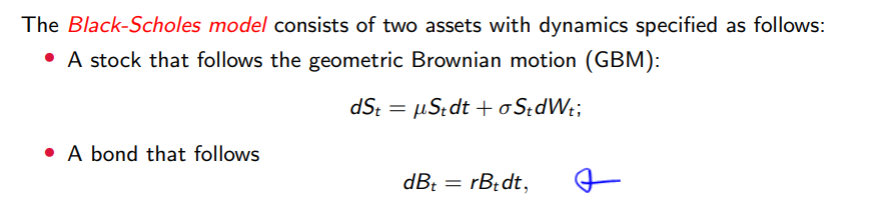

In [17]:
np.random.seed(42)
n_days = 252
dt = 1 / n_days

In [18]:
combined_df['Risk_Free_Rate'].head()

0    1.4594
1    1.4508
2    1.4478
3    1.4623
4    1.4489
Name: Risk_Free_Rate, dtype: float64

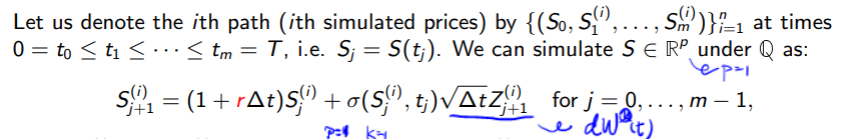

In [19]:
close = combined_df[['ROG_Last_Price', 'CFR_Last_Price', 'ZURN_Last_Price']]
close.cov()

,ROG_Last_Price,CFR_Last_Price,ZURN_Last_Price
ROG_Last_Price,375.344673,-17.563543,286.937174
CFR_Last_Price,-17.563543,133.176550,138.191785
ZURN_Last_Price,286.937174,138.191785,706.118284


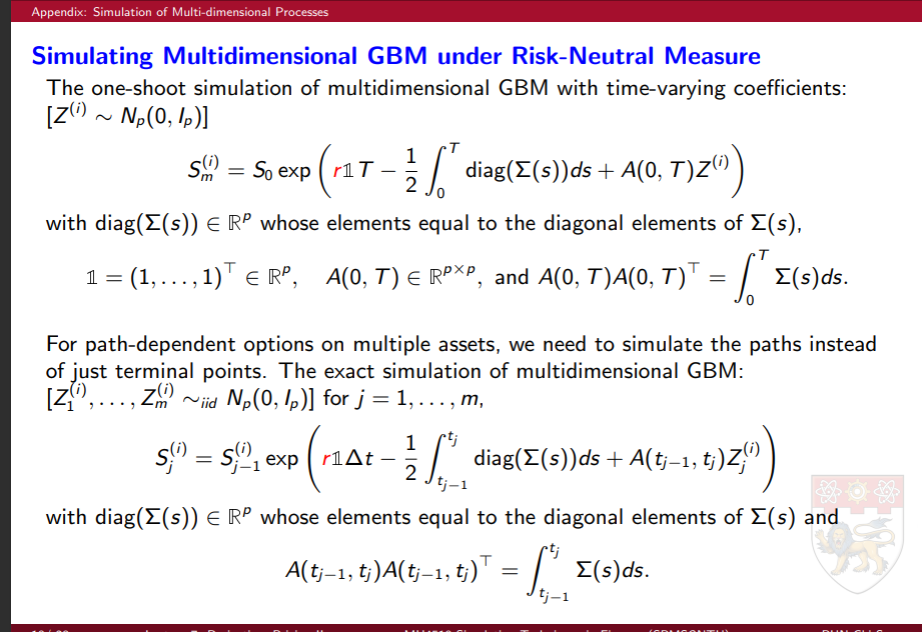

In [20]:
tickers = close.columns

In [21]:
returns = close.pct_change().dropna()

In [22]:
combined_df['Risk_Free_Rate']

0      1.4594
1      1.4508
2      1.4478
3      1.4623
4      1.4489
        ...  
248    0.6532
249    0.6544
250    0.6448
251    0.6213
252       NaN
Name: Risk_Free_Rate, Length: 253, dtype: float64

In [ ]:
# Simulating from start


def BlackScholesSimulation(s0=close.iloc[0], 
                           tickers=tickers,
                           dt=dt,
                           drift=combined_df['Risk_Free_Rate'].values / 100,
                           volatility=returns.cov() * n_days,
                           n_paths=10,
                           T=1, # Time horizon in year:
                           ):
    
    n_steps = int(T / dt)
    result = np.zeros((len(tickers), n_paths, n_steps))

    for i in tqdm(range(n_paths)):
        choleskyMatrix = np.linalg.cholesky(volatility)
        e = np.random.normal(size=(len(tickers), n_steps)) # Generate RV for steps

        for j in range(n_steps):
            for k in range(len(tickers)):
                if(j==0):
                    result[k, i, j] = s0[tickers[k]]
                else:
                    if isinstance(drift, np.ndarray):
                        result[k, i, j] = result[k, i, j-1] * np.exp(
                            (drift[j] -  1/2 * np.sqrt(volatility.iloc[k, k])) * dt + 
                            np.sqrt(dt) * choleskyMatrix[k, k] * e[k, j])
                    else:
                        result[k, i, j] = result[k, i, j-1] * np.exp(
                            (drift -  1/2 * np.sqrt(volatility.iloc[k, k])) * dt + 
                            np.sqrt(dt) * choleskyMatrix[k, k] * e[k, j])
                    
    
    return result, tickers


        


In [24]:
result, tickers = BlackScholesSimulation(s0=close.iloc[-1],
                                         n_paths=1000,
                                         drift=0.01,
                                         T=dt * 40,
                                         volatility=10 * returns.cov() * n_days,)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [25]:
print(f'''{tickers[0]}: {np.mean(result[0])}\n{tickers[1]}: {np.mean(result[1])}\n{tickers[2]}: {np.mean(result[2])}''')

ROG_Last_Price: 278.85596890891077
CFR_Last_Price: 126.59844769082498
ZURN_Last_Price: 515.3353113062891


In [26]:
import sys
sys.path.append('../utils/')
from payoff import *

payoff = []

for i in range(result.shape[1]):
    payoff.append(payoff_func(result[0][i], result[1][i], result[2][i]))

Hello
Worst performance: 0.5414012738853503
Barrier event reached: True
Close above initial: 0
Final payoff: 628.9012738853503
Hello
Worst performance: 0.72327189846178
Barrier event reached: False
Close above initial: 1
Hello
Worst performance: 0.9546289945136346
Barrier event reached: False
Close above initial: 2
Hello
Worst performance: 0.9019027155763322
Barrier event reached: False
Close above initial: 2
Hello
Worst performance: 1.1212648731750379
Barrier event reached: False
Close above initial: 3
Hello
Worst performance: 0.5635783806720986
Barrier event reached: True
Close above initial: 1
Hello
Worst performance: 0.8433554464921974
Barrier event reached: False
Close above initial: 2
Hello
Worst performance: 0.8064091212227312
Barrier event reached: False
Close above initial: 2
Hello
Worst performance: 1.1782409262168219
Barrier event reached: False
Close above initial: 3
Hello
Worst performance: 0.9026760499268849
Barrier event reached: False
Close above initial: 2
Hello
Worst 